In [27]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from tensorflow.keras import layers
import os
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import Sequential
from tensorflow.python.keras import backend as K
from collections import Counter
import random

In [28]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.18.0
Num GPUs Available:  0


In [29]:
# Load the dataset without any predefined batch size
train_data = tf.keras.utils.image_dataset_from_directory(
    'images/train',
    labels='inferred',
    label_mode='int',
    batch_size=None,  # Load as unbatched dataset
    image_size=(48, 48),  # Resize images to standard size
    seed=42 
)

Found 28679 files belonging to 7 classes.


In [30]:
test_data = keras.utils.image_dataset_from_directory(
    directory = 'images/test',
    labels = 'inferred',
    label_mode = 'int',
    color_mode = 'grayscale',
    batch_size = 120,
    image_size = (48, 48),
    seed=42 
)

Found 7177 files belonging to 7 classes.


In [31]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [32]:
# Class names
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [33]:
# Extract data from train dataset
def extract_images_and_labels(dataset):
    X, y = [], []
    for image, label in dataset:
        X.append(image.numpy())
        y.append(label.numpy())
    return np.array(X), np.array(y)

# Assuming train_data is loaded correctly
X, y = extract_images_and_labels(train_data)

In [34]:
print(f'X shape before augmentation: {X.shape}')
print(f'y shape before augmentation: {y.shape}')

X shape before augmentation: (28679, 48, 48, 3)
y shape before augmentation: (28679,)


In [35]:
def data_augmentation(X, y, target_count=2000, rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                      zoom_range=0.1, brightness_range=(0.95, 1.05), horizontal_flip=True, vertical_flip=True, fill_mode='nearest'):
    # Initialize ImageDataGenerator
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        zoom_range=zoom_range,
        brightness_range=brightness_range,
        horizontal_flip=horizontal_flip,
        vertical_flip=vertical_flip,
        fill_mode=fill_mode
    )

    balanced_X = []
    balanced_y = []
    
    unique_classes = np.unique(y)
    # For each class, augment until reaching the target count
    for class_label in unique_classes:
        class_indices = np.where(y == class_label)[0]
        class_images = X[class_indices]
        class_labels = y[class_indices]
        num_images = class_images.shape[0]

        # Calculate how many augmentations are needed
        augmentations_needed = target_count - num_images
        if augmentations_needed >0:
            # Add original images to balanced dataset
            balanced_X.extend(class_images)
            balanced_y.extend(class_labels)
    
            # Calculate how many augmentations are needed for this class
            augmentations_needed = target_count - num_images
    
            # Augment images until we reach the target count
            while augmentations_needed > 0:
                for img, label in zip(class_images, class_labels):
                    if augmentations_needed <= 0:
                        break
                    img = img.reshape((1,) + img.shape)  # Reshape to (1, height, width, channels)
                    label = label.reshape((1,))  # Reshape to a single label
                    augmented_img = next(datagen.flow(img))  # Generate an augmented image
                    balanced_X.append(augmented_img.squeeze())  # Add augmented image to list
                    balanced_y.append(label.squeeze())  # Add label to list
                    augmentations_needed -= 1
        else:
            balanced_X.extend(class_images[:target_count])
            balanced_y.extend(class_labels[:target_count])

    balanced_X = np.array(balanced_X)
    balanced_y = np.array(balanced_y)

    return balanced_X, balanced_y

In [36]:
X_augmented, y_augmented = data_augmentation(X, y, target_count=4000)

In [37]:
print(f'X shape after augmentation: {X_augmented.shape}')
print(f'y shape after augmentation: {y_augmented.shape}')

X shape after augmentation: (28000, 48, 48, 3)
y shape after augmentation: (28000,)


In [38]:
#convert to channel 1
X_augmented = X_augmented[:, :, :, [0]]

In [39]:
X_augmented.shape

(28000, 48, 48, 1)

In [40]:
Counter(y_augmented)

Counter({np.int32(0): 4000,
         np.int32(1): 4000,
         np.int32(2): 4000,
         np.int32(3): 4000,
         np.int32(4): 4000,
         np.int32(5): 4000,
         np.int32(6): 4000})

In [41]:
from sklearn.model_selection import StratifiedShuffleSplit
X = np.array(X_augmented)  # Images
y = np.array(y_augmented)  # Labels
#X = X_augmented  # Images
#y = y_augmented  # Labels

In [42]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=53)
train_idx, valid_idx = next(strat_split.split(X, y))
X_train = X[train_idx]
y_train = y[train_idx]
X_valid = X[valid_idx]
y_valid = y[valid_idx]

In [43]:
print(X_train.shape)
print(X_valid.shape)

(22400, 48, 48, 1)
(5600, 48, 48, 1)


In [44]:
num_classes = 7

In [45]:
model_file = "my_model.keras"

model = Sequential()
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(48,48,1)))
model.add(Conv2D(32, (3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

C:\Users\wings\miniconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [46]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [47]:
model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [48]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 44, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 20, 20, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 18, 18, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 6, 6, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 879,623 (3.36 MB)

 Trainable params: 879,623 (3.36 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
#Release memory
train_data =0
X = y = 0
balanced_X = balanced_y = 0
X_augmented = y_augmented = 0
final_dataset = 0

In [50]:
history = model.fit(x=X_train, y=y_train, epochs=50, validation_data=(X_valid,y_valid))
#history = model.fit(train_dataset, epochs=50, validation_data=validation_data)

Epoch 1/50
700/700 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.1423 - loss: 1.9459 - val_accuracy: 0.1471 - val_loss: 1.9453
Epoch 2/50
700/700 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.1796 - loss: 1.9334 - val_accuracy: 0.2280 - val_loss: 1.8942
Epoch 3/50
700/700 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.2168 - loss: 1.8711 - val_accuracy: 0.2882 - val_loss: 1.7809
Epoch 4/50
700/700 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.2949 - loss: 1.7766 - val_accuracy: 0.3613 - val_loss: 1.6472
Epoch 5/50
700/700 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.3559 - loss: 1.6743 - val_accuracy: 0.4023 - val_loss: 1.5670
Epoch 6/50
700/700 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.3882 - loss: 1.5847 - val_accuracy: 0.4343 - val_loss: 1.4733
Epoch 7/50
700/700 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.4234 - loss: 1.5066 - val_accuracy: 0.4530 - val_loss: 1.4363
Epoch 8/50
700/700 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.4544 - loss: 1.4387 - 

In [51]:
model.save(model_file)

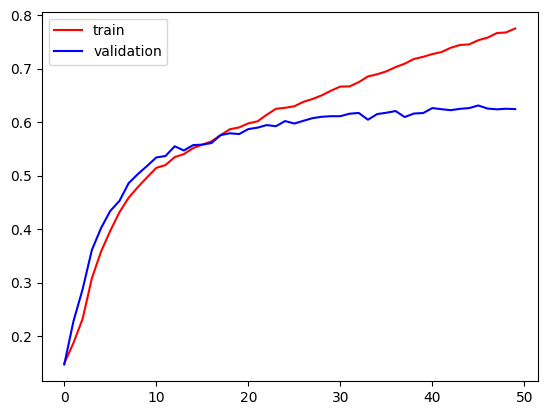

In [52]:
plt.plot(history.history['accuracy'], color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

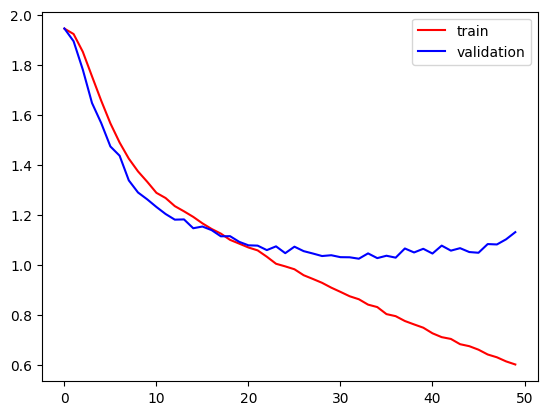

In [53]:
plt.plot(history.history['loss'], color = 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

In [54]:
# Evaluate model
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.5794 - loss: 1.2801
Test Accuracy: 58.51%
